# Borrelia prediction using clinical data only from 2019

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
#from sklearn.metrics import make_scorer, recall_score, precision_score, f1_score, auc, roc_curve
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score, auc, precision_recall_curve
import statsmodels.api as sm

In [4]:
df = pd.read_csv("clean2019_NO_MALARIA.csv")

In [5]:
df

,age,temperature,blood glucose,white blood cell count,lymphocyte count,hemoglobin count,mean cellular volume,red cell distribution width- coefficient of variant,platelet count,platelet distribution width,...,rash_1.0,sore throat_1.0,swelling_1.0,bleeding_1.0,contact with febrile person_1.0,contact with rats_1.0,recent travel_1.0,season_pluie,abdominal pain_1.0,Borrelia
0,2.233036,-1.632621,0.281592,-0.816189,-0.214131,0.260228,0.087648,0.200662,-0.481450,0.015877,...,0,0,0,0,0,1,0,0,0,0
1,-0.678843,1.310524,-0.593305,0.663844,-0.933555,0.707726,-0.557286,1.221399,-0.310789,-0.654233,...,0,0,0,0,0,0,1,0,0,0
2,2.233036,-0.208519,2.801296,-0.569517,0.235508,1.199974,0.916848,0.200662,-0.424563,0.015877,...,0,0,0,0,0,1,1,0,0,0
3,0.569105,-1.062980,-0.138359,-0.035061,1.404570,0.595851,-2.399953,1.221399,0.258081,-0.386189,...,0,0,0,0,0,1,1,0,1,0
4,-0.332191,-0.873100,-0.068367,-1.288978,-0.843627,1.043350,-0.849041,0.107868,-0.841734,0.551966,...,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,0.291783,0.076302,2.136374,0.067720,-0.034276,0.260228,0.195137,-0.263309,0.125344,0.685988,...,0,0,0,0,0,0,1,1,0,0
159,-0.678843,0.076302,-0.278342,-0.003437,-0.002435,0.005348,-0.006609,0.001461,-0.019508,0.009901,...,0,1,0,1,1,1,0,1,0,0
160,2.233036,-0.018639,-1.678178,0.561064,-0.034276,0.886725,2.452404,-0.634486,-0.490931,0.551966,...,0,1,0,0,1,1,1,1,0,0
161,-0.748174,3.399207,-0.031347,1.629977,-0.393987,0.573477,-0.311597,-0.820075,-0.244421,0.820010,...,0,0,0,0,0,1,0,1,0,1


In [7]:
df.columns


Index(['age', 'temperature', 'blood glucose', 'white blood cell count',
       'lymphocyte count', 'hemoglobin count', 'mean cellular volume',
       'red cell distribution width- coefficient of variant', 'platelet count',
       'platelet distribution width', 'heart rate category_encoded', 'sex_F',
       'prior antibiotics_1.0', 'prior antimalarials_1.0', 'headache_1.0',
       'body aches_1.0', 'dizziness_1.0', 'vomitting_1.0',
       'fatigue/weakness_1.0', 'chest pain_1.0', 'difficulty breathing_1.0',
       'rash_1.0', 'sore throat_1.0', 'swelling_1.0', 'bleeding_1.0',
       'contact with febrile person_1.0', 'contact with rats_1.0',
       'recent travel_1.0', 'season_pluie', 'abdominal pain_1.0', 'Borrelia'],
      dtype='object')

In [8]:
#Removing all Lab data to remain with clinical data only

# Delete column temperature, 
df1 = df.drop(['white blood cell count','lymphocyte count', 'hemoglobin count', 'mean cellular volume',
       'red cell distribution width- coefficient of variant', 'platelet count',
       'platelet distribution width', 'blood glucose'], axis=1)


# Print the updated DataFrame
print("Updated DataFrame:")
print(df1)


Updated DataFrame:
          age  temperature  heart rate category_encoded  sex_F  \
0    2.233036    -1.632621                            2      1   
1   -0.678843     1.310524                            2      1   
2    2.233036    -0.208519                            0      1   
3    0.569105    -1.062980                            2      0   
4   -0.332191    -0.873100                            2      1   
..        ...          ...                          ...    ...   
158  0.291783     0.076302                            0      1   
159 -0.678843     0.076302                            1      0   
160  2.233036    -0.018639                            2      0   
161 -0.748174     3.399207                            2      1   
162 -0.470852    -0.018639                            2      0   

     prior antibiotics_1.0  prior antimalarials_1.0  headache_1.0  \
0                        0                        0             1   
1                        0                        

In [9]:
#FEATURE SELECTION 

from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.metrics import roc_auc_score as auc
from sklearn.model_selection import cross_val_score
import xgboost as xgb

In [10]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
data = df1.copy()
X = data.iloc[:, :-1]  #independent columns
y = data.iloc[:,-1]    #target column 

In [11]:
import time
from sklearn.metrics import SCORERS
#print(list(SCORERS.keys()))

In [15]:
# Just for purpose of sharing this piece of code
# Create an automated routine to test different K values for mutual_info_classif
#mutual_info_classif considers both categorical and numerical features - will be used in this analysis

K_vs_score_mic = [] #List to store AUC of each K with mutual_info_classif


for k in range(2, 22, 2):
    start = time.time()
    
    # Instantiating a KBest object for each of the metrics in order to obtain the K features with the highest value
    selector_mic = SelectKBest(score_func = mutual_info_classif, k = k)
    
    # Selecting K-features and modifying the dataset
    X_selected_mic = selector_mic.fit_transform(X, y) 
    
    # Instantiating an XGBClassifier object
    clf = xgb.XGBClassifier(seed=42)
    
    # Using 10-CV to calculate weighted AUC for each K value avoiding overfitting & handling class imbalance
    auc_mic = cross_val_score(clf, X_selected_mic, y, cv = 10, scoring = 'roc_auc_ovr_weighted')
    
    # Adding the average values obtained in the CV for further analysis.
    K_vs_score_mic.append(auc_mic.mean())
    
    end = time.time()
    # Returning the metrics related to the tested K and the time spent on this iteration of the loop
    print("k = {} - auc_mic = {} - Time = {}s".format(k, auc_mic.mean(), end-start))

k = 2 - auc_mic = 0.7045238095238096 - Time = 2.125716209411621s
k = 4 - auc_mic = 0.6948809523809523 - Time = 2.088763952255249s
k = 6 - auc_mic = 0.6103571428571429 - Time = 2.1366939544677734s
k = 8 - auc_mic = 0.6692857142857143 - Time = 1.4193589687347412s
k = 10 - auc_mic = 0.7233333333333334 - Time = 1.49418306350708s
k = 12 - auc_mic = 0.6564285714285715 - Time = 1.3870818614959717s
k = 14 - auc_mic = 0.719047619047619 - Time = 1.596426010131836s
k = 16 - auc_mic = 0.6397619047619048 - Time = 1.537726879119873s
k = 18 - auc_mic = 0.6404761904761906 - Time = 1.4847080707550049s
k = 20 - auc_mic = 0.6357142857142856 - Time = 1.6595330238342285s


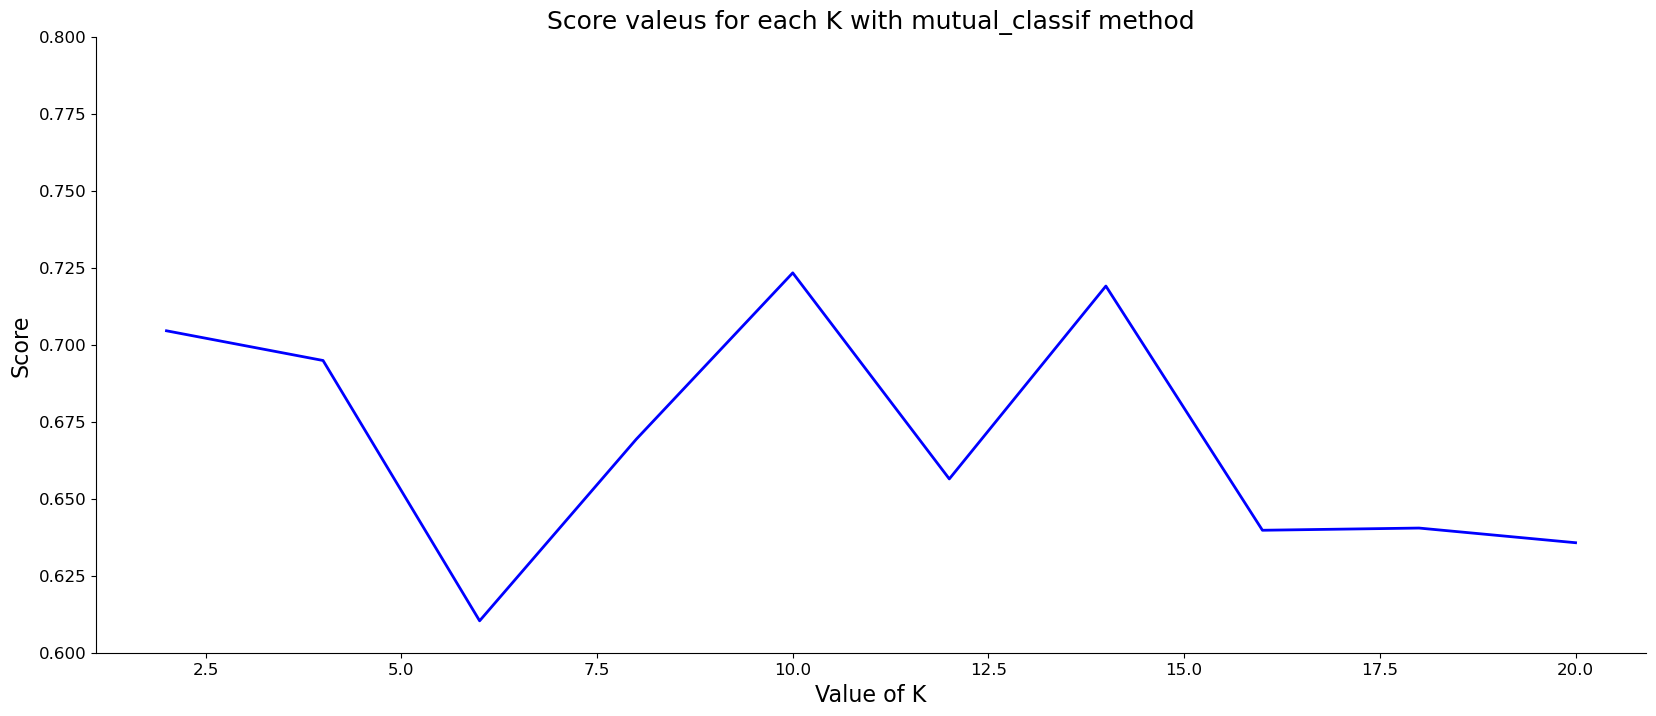

In [16]:
# Ploting K_vs_score_fc (# of K-Best features vs AUC) 
import matplotlib.patches as patches
import matplotlib.pyplot as plt

# Figure setup
fig, ax = plt.subplots(1, figsize = (20, 8))
plt.title('Score valeus for each K with mutual_classif method', fontsize=18)
plt.ylabel('Score', fontsize = 16)
plt.xlabel('Value of K', fontsize = 16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

# Create the lines
plt.plot(np.arange(2, 22, 2), K_vs_score_mic, color='blue', linewidth=2)
ax.set_ylim(0.60, 0.80);

# Create a Rectangle patch
#rect = patches.Rectangle((1, 0.7175), 5, (0.73 - 0.7175), linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
#ax.add_patch(rect)

plt.show()


In [17]:
from imblearn.over_sampling import SMOTE

In [18]:
# Create an automated routine to test different K values for mutual_info_classif
#mutual_info_classif considers both categorical and numerical features

# Apply SMOTE for oversampling the minority class
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

K_vs_score_mic = [] #List to store AUC of each K with mutual_info_classif

for k in range(2, 22, 2):
    start = time.time()
    
    # Instantiating a KBest object for each of the metrics in order to obtain the K features with the highest value
    selector_mic = SelectKBest(score_func = mutual_info_classif, k = k)
    
    # Selecting K-features and modifying the dataset
    X_selected_mic = selector_mic.fit_transform(X_resampled, y_resampled) 
    
    # Instantiating an XGBClassifier object
    clf = xgb.XGBClassifier(seed=42)
    
    # Using 10-CV to calculate AUC for each K value avoinding overfitting
    auc_mic = cross_val_score(clf, X_selected_mic, y_resampled, cv = 10, scoring = 'f1')
    
    # Adding the average values obtained in the CV for further analysis.
    K_vs_score_mic.append(auc_mic.mean())
    
    end = time.time()
    # Returning the metrics related to the tested K and the time spent on this iteration of the loop
    print("k = {} - auc_mic = {} - Time = {}s".format(k, auc_mic.mean(), end-start))

k = 2 - auc_mic = 0.8064027564430791 - Time = 2.519185781478882s
k = 4 - auc_mic = 0.8296148101064675 - Time = 1.8574531078338623s
k = 6 - auc_mic = 0.8534819552589296 - Time = 2.2714908123016357s
k = 8 - auc_mic = 0.8625229497976996 - Time = 1.7434558868408203s
k = 10 - auc_mic = 0.873246170053734 - Time = 1.861630916595459s
k = 12 - auc_mic = 0.8599069478908188 - Time = 2.1809659004211426s
k = 14 - auc_mic = 0.8654361327400816 - Time = 2.086164951324463s
k = 16 - auc_mic = 0.8705990783410137 - Time = 1.9434618949890137s
k = 18 - auc_mic = 0.885694139420502 - Time = 2.1207470893859863s
k = 20 - auc_mic = 0.9008704828727074 - Time = 1.8928959369659424s


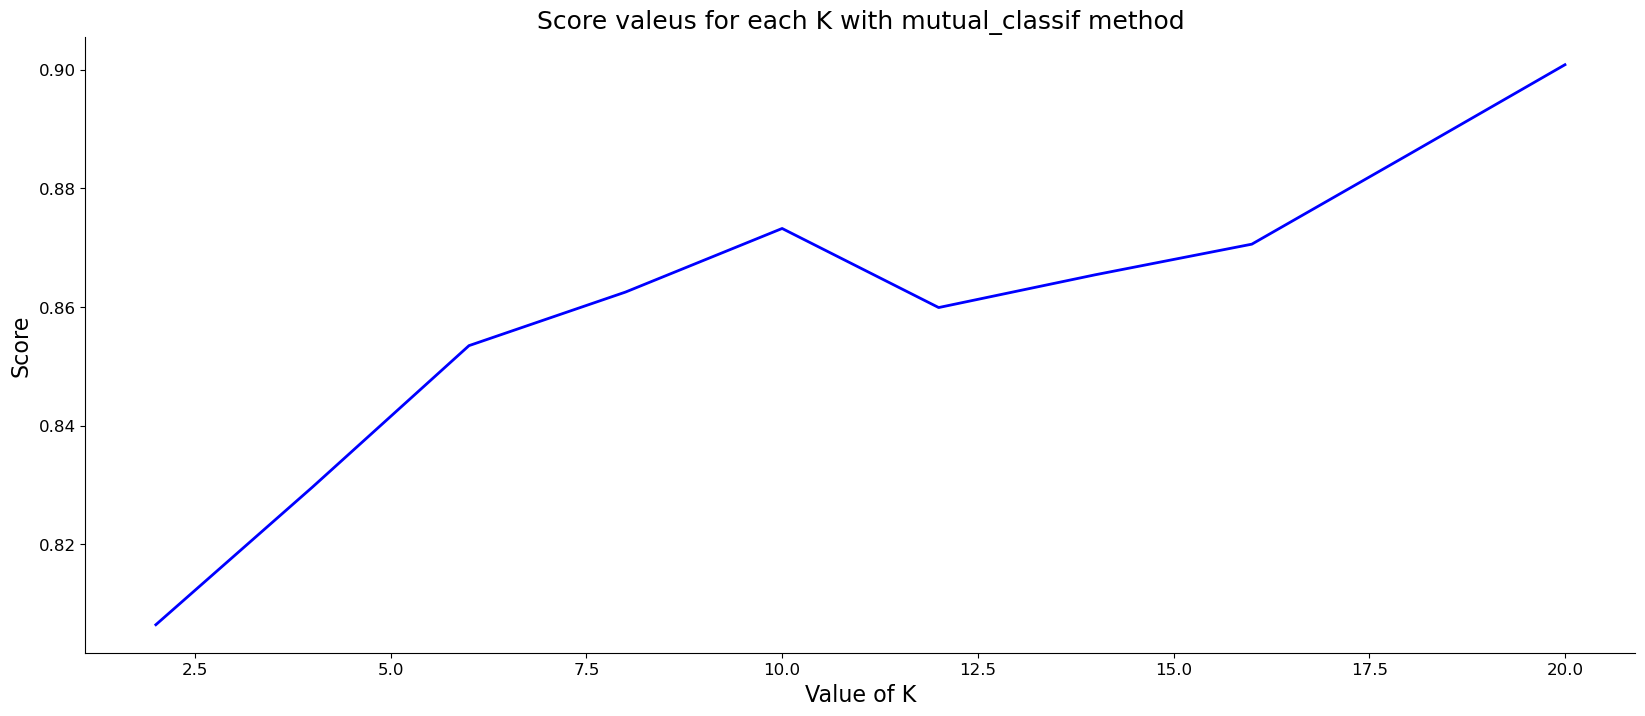

In [20]:
# Ploting K_vs_score_mic (# of K-Best features vs f1)

# Figure setup
fig, ax = plt.subplots(figsize = (20, 8))
plt.title('Score valeus for each K with mutual_classif method', fontsize=18)
plt.ylabel('Score', fontsize = 16)
plt.xlabel('Value of K', fontsize = 16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

# Create the lines
plt.plot(np.arange(2, 22, 2), K_vs_score_mic, color='blue', linewidth=2)

plt.show()

In [21]:
mask_selected = selector_mic.get_support()
# Saving the selected columns in a list
selected_col = X.columns[mask_selected]
selected_col

Index(['age', 'temperature', 'heart rate category_encoded', 'sex_F',
       'prior antibiotics_1.0', 'headache_1.0', 'dizziness_1.0',
       'vomitting_1.0', 'fatigue/weakness_1.0', 'chest pain_1.0',
       'difficulty breathing_1.0', 'rash_1.0', 'sore throat_1.0',
       'swelling_1.0', 'bleeding_1.0', 'contact with febrile person_1.0',
       'contact with rats_1.0', 'recent travel_1.0', 'season_pluie',
       'abdominal pain_1.0'],
      dtype='object')

In [22]:
mask_selected = selector_mic.get_support()
# Saving the selected columns in a list
selected_col = X_resampled.columns[mask_selected]
selected_col

Index(['age', 'temperature', 'heart rate category_encoded', 'sex_F',
       'prior antibiotics_1.0', 'headache_1.0', 'dizziness_1.0',
       'vomitting_1.0', 'fatigue/weakness_1.0', 'chest pain_1.0',
       'difficulty breathing_1.0', 'rash_1.0', 'sore throat_1.0',
       'swelling_1.0', 'bleeding_1.0', 'contact with febrile person_1.0',
       'contact with rats_1.0', 'recent travel_1.0', 'season_pluie',
       'abdominal pain_1.0'],
      dtype='object')

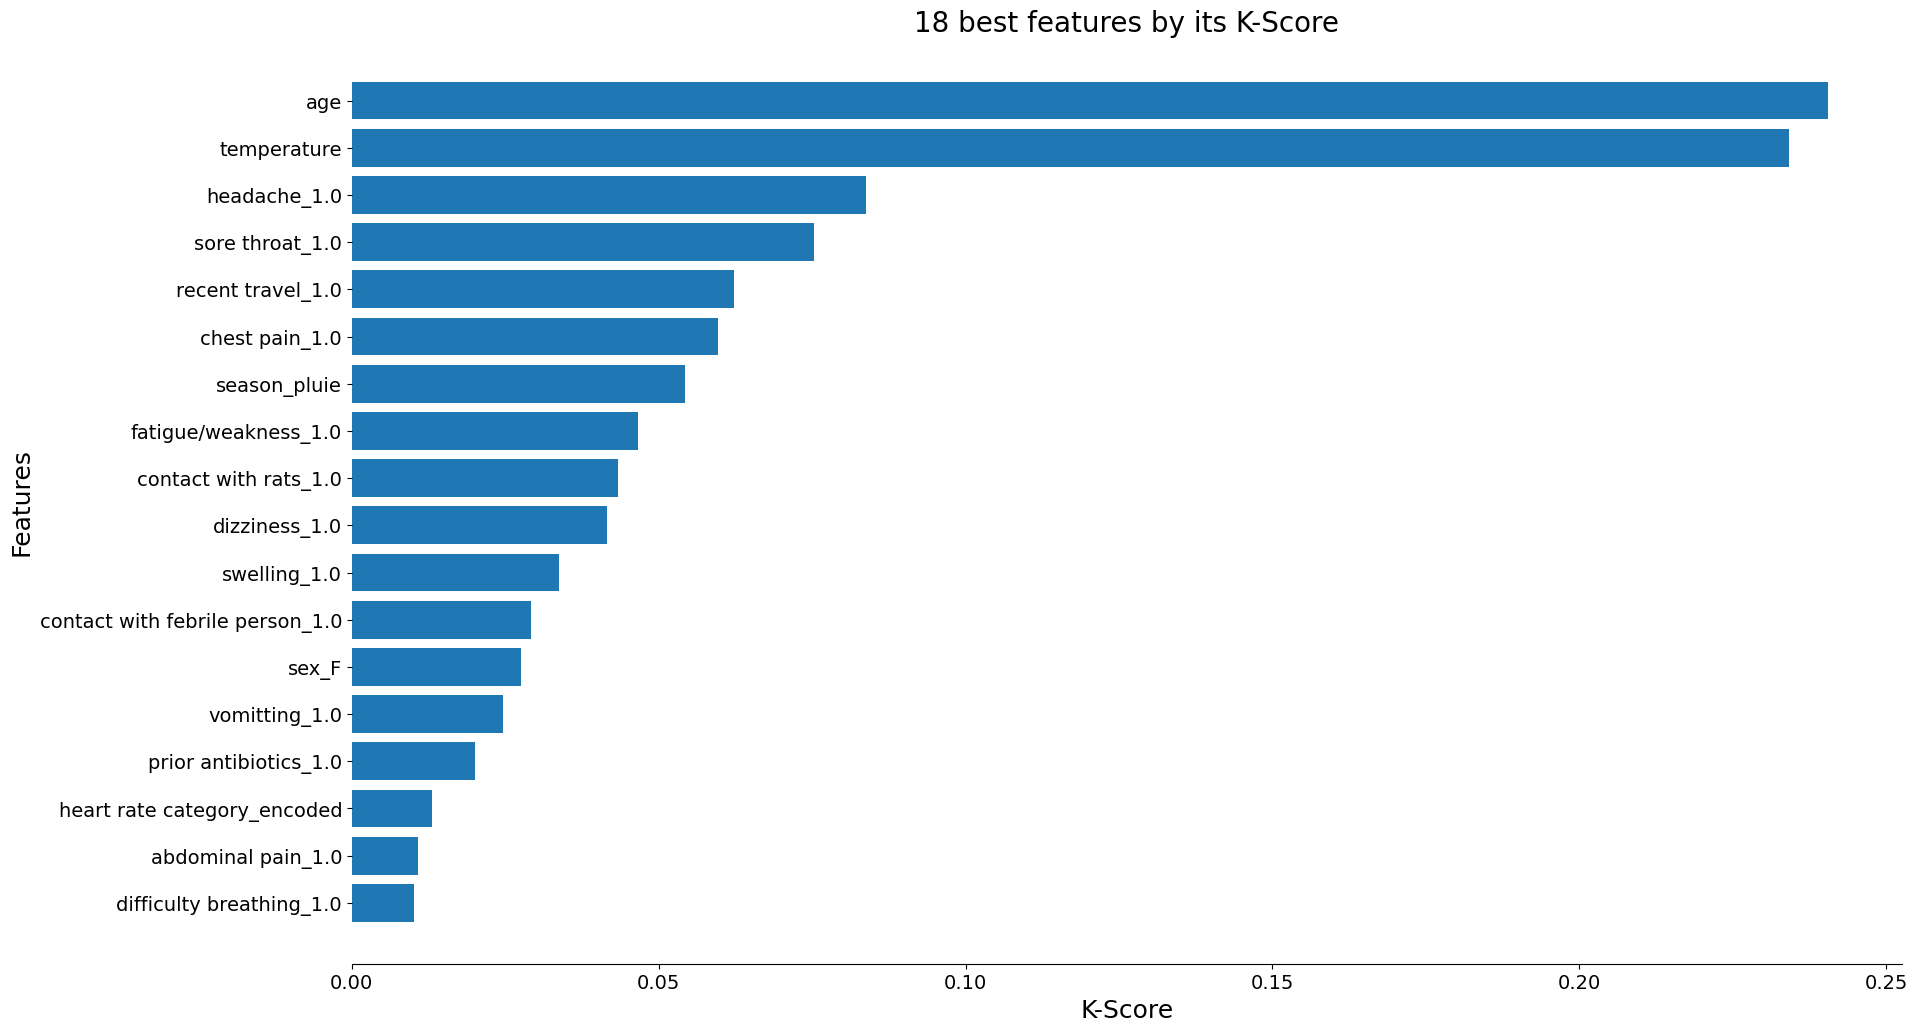

In [23]:
#Plot the features of importance
feature_score = pd.Series(selector_mic.scores_, index=X_resampled.columns).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(20, 12))
ax.barh(feature_score.index[0:18], feature_score[0:18])
plt.gca().invert_yaxis()


ax.set_xlabel('K-Score', fontsize=18);
ax.set_ylabel('Features', fontsize=18);
ax.set_title('18 best features by its K-Score', fontsize = 20)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False);

In [24]:
#We will use 18 features selected using the mutual_info_classif and subject them to RFE

In [25]:
df1

,age,temperature,heart rate category_encoded,sex_F,prior antibiotics_1.0,prior antimalarials_1.0,headache_1.0,body aches_1.0,dizziness_1.0,vomitting_1.0,...,rash_1.0,sore throat_1.0,swelling_1.0,bleeding_1.0,contact with febrile person_1.0,contact with rats_1.0,recent travel_1.0,season_pluie,abdominal pain_1.0,Borrelia
0,2.233036,-1.632621,2,1,0,0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,-0.678843,1.310524,2,1,0,0,1,1,1,1,...,0,0,0,0,0,0,1,0,0,0
2,2.233036,-0.208519,0,1,0,0,1,1,0,0,...,0,0,0,0,0,1,1,0,0,0
3,0.569105,-1.062980,2,0,0,0,1,1,1,0,...,0,0,0,0,0,1,1,0,1,0
4,-0.332191,-0.873100,2,1,0,0,1,0,0,1,...,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,0.291783,0.076302,0,1,0,0,1,1,0,0,...,0,0,0,0,0,0,1,1,0,0
159,-0.678843,0.076302,1,0,0,0,1,0,1,0,...,0,1,0,1,1,1,0,1,0,0
160,2.233036,-0.018639,2,0,0,0,1,0,1,0,...,0,1,0,0,1,1,1,1,0,0
161,-0.748174,3.399207,2,1,0,0,1,0,1,1,...,0,0,0,0,0,1,0,1,0,1


In [26]:
df_RFE = df[['age', 'temperature', 'heart rate category_encoded', 'sex_F',
       'prior antibiotics_1.0', 'headache_1.0', 'dizziness_1.0',
       'vomitting_1.0', 'fatigue/weakness_1.0', 'chest pain_1.0',
       'difficulty breathing_1.0', 'rash_1.0', 'sore throat_1.0',
       'swelling_1.0', 'bleeding_1.0', 'contact with febrile person_1.0',
       'contact with rats_1.0', 'recent travel_1.0', 'season_pluie',
       'abdominal pain_1.0', 'Borrelia']]

In [27]:
df_RFE

,age,temperature,heart rate category_encoded,sex_F,prior antibiotics_1.0,headache_1.0,dizziness_1.0,vomitting_1.0,fatigue/weakness_1.0,chest pain_1.0,...,rash_1.0,sore throat_1.0,swelling_1.0,bleeding_1.0,contact with febrile person_1.0,contact with rats_1.0,recent travel_1.0,season_pluie,abdominal pain_1.0,Borrelia
0,2.233036,-1.632621,2,1,0,1,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,-0.678843,1.310524,2,1,0,1,1,1,1,1,...,0,0,0,0,0,0,1,0,0,0
2,2.233036,-0.208519,0,1,0,1,0,0,1,1,...,0,0,0,0,0,1,1,0,0,0
3,0.569105,-1.062980,2,0,0,1,1,0,1,1,...,0,0,0,0,0,1,1,0,1,0
4,-0.332191,-0.873100,2,1,0,1,0,1,1,0,...,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,0.291783,0.076302,0,1,0,1,0,0,1,1,...,0,0,0,0,0,0,1,1,0,0
159,-0.678843,0.076302,1,0,0,1,1,0,0,0,...,0,1,0,1,1,1,0,1,0,0
160,2.233036,-0.018639,2,0,0,1,1,0,1,0,...,0,1,0,0,1,1,1,1,0,0
161,-0.748174,3.399207,2,1,0,1,1,1,1,0,...,0,0,0,0,0,1,0,1,0,1


In [28]:
data = df_RFE.copy()

X = data.iloc[:, :-1]  #independent columns
y = data.iloc[:,-1]    #target column 

In [43]:
#SMOTE, Logistic regression, RFE

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, f1_score
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score, auc, precision_recall_curve
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Apply SMOTE for oversampling the minority class in the train set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Initialize the logistic regression model
logreg_model = LogisticRegression()

# Initialize the RFE object with the logistic regression model and desired number of features
num_features_to_select = 12  # Replace with your desired number of features (try with sizes between 10 and 16 and choose the one with highest F1 score)
rfe = RFE(estimator=logreg_model, n_features_to_select=num_features_to_select)

# Fit RFE to the resampled training data
rfe.fit(X_train_resampled, y_train_resampled)

# Get the selected features
selected_features = X_train.columns[rfe.support_]

# Filter the resampled training and testing data with selected features
X_train_selected = X_train_resampled[selected_features]
#X_test_selected = X_test[selected_features]

# Perform cross-validation using F1-score as the evaluation metric
f1_scorer = make_scorer(f1_score)
f1cv_scores = cross_val_score(logreg_model, X_train_selected, y_train_resampled, cv=5, scoring=f1_scorer)

# Print cross-validation scores
#print("Cross-Validation F1 Scores:", f1cv_scores)
print("Mean CV F1 Score:", np.mean(f1cv_scores))


recall_scorer = make_scorer(recall_score)
recallcv_scores = cross_val_score(logreg_model, X_train_selected, y_train_resampled, cv=5, scoring=recall_scorer)

precision_scorer = make_scorer(precision_score)
precisioncv_scores = cross_val_score(logreg_model, X_train_selected, y_train_resampled, cv=5, scoring=precision_scorer)


# Print cross-validation scores
print("Mean CV recall Score:", np.mean(recallcv_scores))
print("Mean CV precision Score:", np.mean(precisioncv_scores))

Mean CV F1 Score: 0.8038598403176895
Mean CV recall Score: 0.8008547008547009
Mean CV precision Score: 0.8138662967467315


In [44]:
cols_to_keep=X.columns[rfe.support_]

In [45]:
cols_to_keep #12 features had highest F1 score. so we will train model with 12 features

Index(['temperature', 'heart rate category_encoded', 'sex_F',
       'prior antibiotics_1.0', 'headache_1.0', 'dizziness_1.0',
       'fatigue/weakness_1.0', 'difficulty breathing_1.0', 'sore throat_1.0',
       'bleeding_1.0', 'recent travel_1.0', 'season_pluie'],
      dtype='object')

In [46]:
data2 = df1[['temperature', 'heart rate category_encoded', 'sex_F',
       'prior antibiotics_1.0', 'headache_1.0', 'dizziness_1.0',
       'fatigue/weakness_1.0', 'difficulty breathing_1.0', 'sore throat_1.0',
       'bleeding_1.0', 'recent travel_1.0', 'season_pluie', 'Borrelia']]

X = data2.iloc[:, :-1]  #independent columns
y = data2.iloc[:,-1]    #target column 

In [47]:
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.utils import resample
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score, auc, precision_recall_curve
from sklearn.model_selection import KFold
from scipy.stats import sem

# Apply SMOTE to oversample the minority class
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Lasso logistic regression model with cross-validation for alpha selection
# alphas = [0.1, 0.5, 1.0, 5.0]  # Add more values if needed
lasso = LassoCV(cv=5, max_iter=10000)

# Fit the Lasso model to the resampled data
lasso.fit(X_resampled, y_resampled)

# Get the selected features using Lasso (non-zero coefficients)
selected_features = X.columns[lasso.coef_ != 0]

# Filter the data using the selected features
X_selected = X_resampled[selected_features]

# Weighted logistic regression model
weighted_logreg = LogisticRegression(class_weight='balanced')

# Number of bootstrap iterations
n_bootstrap = 1000

# Create lists to store the bootstrap results
recall_bootstraps = []
precision_bootstraps = []
f1_score_bootstraps = []
auc_roc_bootstraps = []
auc_pr_bootstraps = []
odds_ratio_bootstraps = []

# Store the coefficient estimates from each iteration
coefficient_samples = []

# Perform optimism bootstrap using KFold cross-validation

for i in range(n_bootstrap):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for train_index, test_index in kf.split(X_selected, y_resampled):
        X_train, X_test = X_selected.iloc[train_index], X_selected.iloc[test_index]
        y_train, y_test = y_resampled[train_index], y_resampled[test_index]
    
        # Fit the weighted logistic regression model to the training data
        weighted_logreg.fit(X_train, y_train)
    
        # Store the coefficient estimates
        coefficient_samples.append(weighted_logreg.coef_[0])

        # Predict on the test set
        y_pred_test = weighted_logreg.predict(X_test)

        # Calculate recall, precision, and F1 score for the test set
        recall_bootstraps.append(recall_score(y_test, y_pred_test))
        precision_bootstraps.append(precision_score(y_test, y_pred_test))
        f1_score_bootstraps.append(f1_score(y_test, y_pred_test))

        # Calculate AUC-ROC curve for the test set
        y_pred_prob_test = weighted_logreg.predict_proba(X_test)[:, 1]
        auc_roc_bootstraps.append(roc_auc_score(y_test, y_pred_prob_test))

        # Calculate AUC-PR curve for the test set
        precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_prob_test)
        auc_pr_bootstraps.append(auc(recall_curve, precision_curve))

        # Calculate odds ratio
        odds_ratio_bootstraps.append(np.exp(weighted_logreg.coef_[0][0]))
    
# Calculate confidence intervals for metrics
recall_ci = np.percentile(recall_bootstraps, [2.5, 97.5])
precision_ci = np.percentile(precision_bootstraps, [2.5, 97.5])
f1_score_ci = np.percentile(f1_score_bootstraps, [2.5, 97.5])
auc_roc_ci = np.percentile(auc_roc_bootstraps, [2.5, 97.5])
auc_pr_ci = np.percentile(auc_pr_bootstraps, [2.5, 97.5])
odds_ratio_ci = np.percentile(odds_ratio_bootstraps, [2.5, 97.5])

# Print evaluation metrics with confidence intervals
print("Recall: {:.3f} [{:.3f} - {:.3f}]".format(np.mean(recall_bootstraps), recall_ci[0], recall_ci[1]))
print("Precision: {:.3f} [{:.3f} - {:.3f}]".format(np.mean(precision_bootstraps), precision_ci[0], precision_ci[1]))
print("F1 Score: {:.3f} [{:.3f} - {:.3f}]".format(np.mean(f1_score_bootstraps), f1_score_ci[0], f1_score_ci[1]))
print("AUC-ROC: {:.3f} [{:.3f} - {:.3f}]".format(np.mean(auc_roc_bootstraps), auc_roc_ci[0], auc_roc_ci[1]))
print("AUC-PR: {:.3f} [{:.3f} - {:.3f}]".format(np.mean(auc_pr_bootstraps), auc_pr_ci[0], auc_pr_ci[1]))
print("Odds Ratio: {:.3f} [{:.3f} - {:.3f}]".format(np.mean(odds_ratio_bootstraps), odds_ratio_ci[0], odds_ratio_ci[1]))

# Calculate the confidence intervals for each coefficient
alpha = 0.95  # 95% confidence interval
lower_percentile = (1 - alpha) / 2
upper_percentile = 1 - lower_percentile
confidence_intervals = np.percentile(coefficient_samples, [lower_percentile * 100, upper_percentile * 100], axis=0)

# Print the confidence intervals
columns = X.columns
for i, column in enumerate(selected_features):
    print(f"Coefficient for {column}: {weighted_logreg.coef_[0][i]:.3f} (95% CI: {confidence_intervals[0][i]:.3f}, {confidence_intervals[1][i]:.3f})")
    


Recall: 0.815 [0.710 - 0.885]
Precision: 0.773 [0.625 - 0.833]
F1 Score: 0.793 [0.678 - 0.853]
AUC-ROC: 0.871 [0.808 - 0.934]
AUC-PR: 0.871 [0.819 - 0.923]
Odds Ratio: 2.191 [1.995 - 2.361]
Coefficient for temperature: 0.691 (95% CI: 0.691, 0.859)
Coefficient for heart rate category_encoded: -0.159 (95% CI: -0.344, -0.142)
Coefficient for sex_F: -1.372 (95% CI: -1.619, -1.154)
Coefficient for prior antibiotics_1.0: -1.149 (95% CI: -1.530, -1.149)
Coefficient for headache_1.0: 0.993 (95% CI: 0.671, 1.004)
Coefficient for dizziness_1.0: -0.771 (95% CI: -1.073, -0.771)
Coefficient for fatigue/weakness_1.0: -0.707 (95% CI: -0.707, -0.507)
Coefficient for difficulty breathing_1.0: -0.240 (95% CI: -0.497, -0.240)
Coefficient for sore throat_1.0: -2.367 (95% CI: -2.462, -1.978)
Coefficient for bleeding_1.0: -0.320 (95% CI: -0.343, -0.078)
Coefficient for recent travel_1.0: -0.320 (95% CI: -0.707, -0.242)
Coefficient for season_pluie: -1.158 (95% CI: -1.451, -1.158)


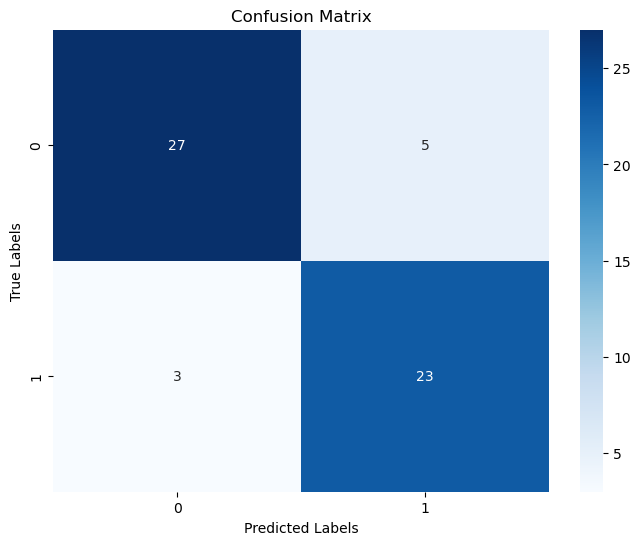

In [48]:
from sklearn.metrics import accuracy_score, confusion_matrix,roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.metrics import f1_score


import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming you have true labels (y_test) and predicted probabilities (y_pred_prob_test)
# Convert probabilities to binary predictions using a threshold (e.g., 0.5)
y_pred_test = np.where(y_pred_prob_test >= 0.5, 1, 0)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and axis ticks
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


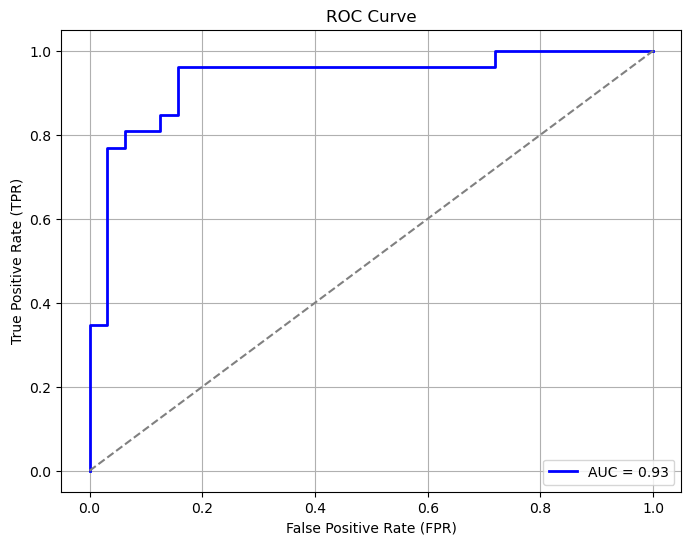

In [49]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_test)

# Compute AUC score
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

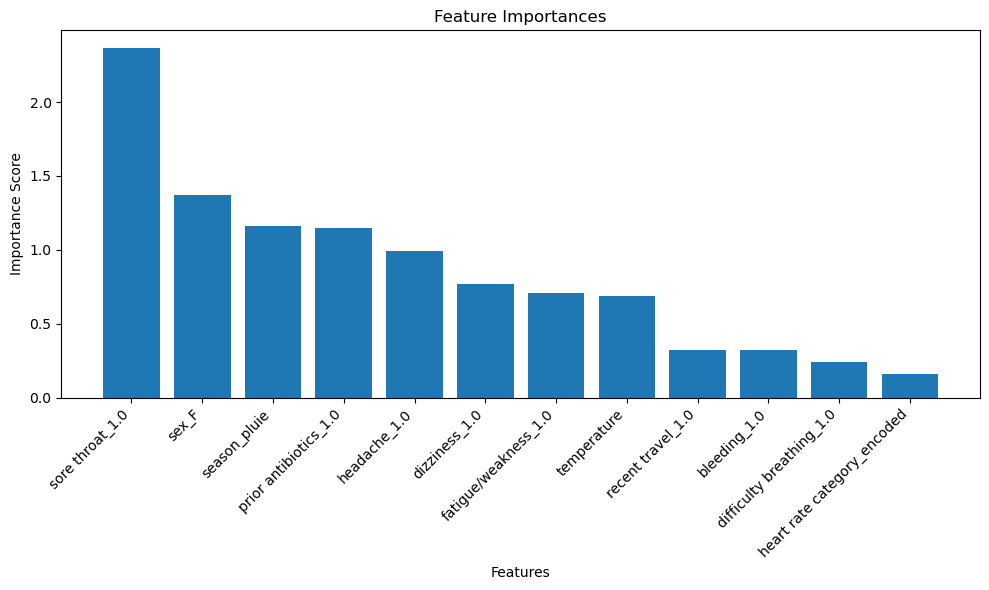

In [50]:
# Get the absolute values of the coefficients and sort them in descending order
feature_importance_scores = np.abs(weighted_logreg.coef_[0])
sorted_feature_importances = sorted(zip(feature_importance_scores, selected_features), reverse=True)

# Extract feature names and importance scores
features, importances = zip(*sorted_feature_importances)

# Create a bar plot with numerical values for bar heights
plt.figure(figsize=(10, 6))
plt.bar(range(len(features)), [score for score, _ in sorted_feature_importances])  # Use list comprehension for bar heights
plt.xticks(range(len(features)), [name for _, name in sorted_feature_importances], rotation=45, ha='right')  # Set xticks with feature names
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.title('Feature Importances')
plt.tight_layout()
plt.show()


In [51]:
feature_labels = []
for feat in selected_features:
    if feat == "sex_F":
        feature_labels.append("female")
    elif feat == "heart rate category_encoded":
        feature_labels.append("heart rate")
    elif feat == "season_pluie" or feat == "season_rainy":
        feature_labels.append("rainy season")
    elif feat == "abdominal pain_1":
        feature_labels.append("abdominal pain")        
    else:
        feature_labels.append(feat.replace("_1.0", ""))

feature_labels

['temperature',
 'heart rate',
 'female',
 'prior antibiotics',
 'headache',
 'dizziness',
 'fatigue/weakness',
 'difficulty breathing',
 'sore throat',
 'bleeding',
 'recent travel',
 'rainy season']

In [52]:
odds = pd.DataFrame({"2.5%": list(np.exp(confidence_intervals[0])),
                     "97.5%": list(np.exp(confidence_intervals[1])),
                     "Odds Ratio": list(np.exp(weighted_logreg.coef_[0]))}, index=feature_labels)
odds

,2.5%,97.5%,Odds Ratio
temperature,1.995078,2.361204,1.995078
heart rate,0.708975,0.867330,0.852595
female,0.198001,0.315346,0.253625
prior antibiotics,0.216429,0.317095,0.317095
headache,1.955457,2.728825,2.698768
dizziness,0.342059,0.462425,0.462425
fatigue/weakness,0.493033,0.602537,0.493033
difficulty breathing,0.608512,0.786446,0.786446
sore throat,0.085251,0.138318,0.093734
bleeding,0.709819,0.925394,0.726084


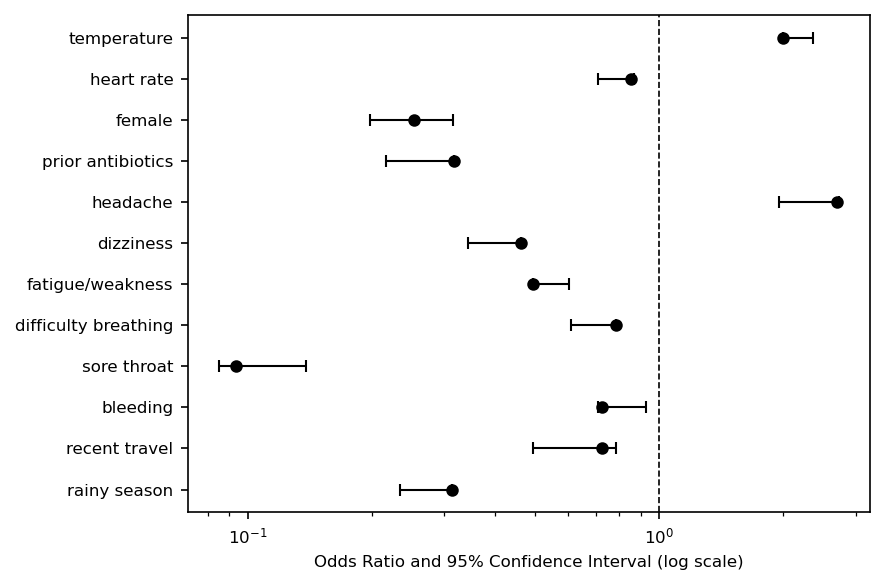

In [54]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4), dpi=150)
ci = [odds.iloc[::-1]['Odds Ratio'] - odds.iloc[::-1]['2.5%'].values, odds.iloc[::-1]['97.5%'].values - odds.iloc[::-1]['Odds Ratio']]
plt.errorbar(x=odds.iloc[::-1]['Odds Ratio'], y=odds.iloc[::-1].index.values, xerr=ci,
            color='black',  capsize=3, linestyle='None', linewidth=1,
            marker="o", markersize=5, mfc="black", mec="black")
plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
plt.tick_params(axis='both', which='major', labelsize=8)
plt.xlabel('Odds Ratio and 95% Confidence Interval (log scale)', fontsize=8)
plt.xscale("log")
plt.tight_layout()
plt.savefig('2019-clinical-or-plot.pdf')
plt.show()